<a href="https://colab.research.google.com/github/YeongSeokJeong/korean_car_plate_recognition/blob/master/car_plate_ocr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import cv2
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import os
from google.colab.patches import cv2_imshow
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

In [9]:
data = []
data_label = []
path = '/content/drive/My Drive/ocr'
img_path_list = os.listdir(path)

In [10]:
label_dic = {}
with open('HallymCarDataset_labels.txt', 'r') as f:
  for line in f.readlines():
    line = line.split()
    label_dic[line[0]] = line[-1]

In [13]:
for img_path in img_path_list:
  step_img = cv2.imread(path + '/' + img_path, 0)
  step_img = cv2.resize(step_img, (200, 50))
  step_img = step_img.astype(np.float32)
  step_img = (step_img/255.).astype(np.float32)
  data.append(step_img)
  data_label.append(label_dic[img_path])

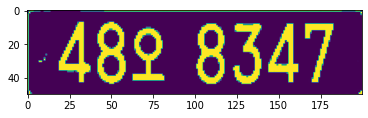

In [17]:
plt.imshow(data[0])

In [76]:
plate_dic = [[c for c in data] for data in data_label ]
print(plate_dic[0])
char_dic_list = [c  for plate in plate_dic for c in plate ]
print(char_dic_list[:10])
char_dic_list = list(set(char_dic_list))
char_dic_list.insert(0, 'pad')
plate_dic = {char : i for i, char in enumerate(char_dic_list)}
to_char_dic = {i : char for i, char in enumerate(char_dic_list)}
data_l = [[plate_dic[c] for c in label] for label in data_label]


['4', '8', '오', '8', '3', '4', '7']
['4', '8', '오', '8', '3', '4', '7', '2', '9', '머']


In [19]:
data_l[0]

[48, 37, 32, 37, 1, 48, 33]

In [20]:
data = np.array(data)

In [21]:
data_l = pad_sequences(data_l, maxlen = 9, padding = 'post')
# data_l = np.expand_dims(data_l, axis = -1)

In [23]:
x_train,x_test, y_train, y_test = train_test_split(data, data_l, test_size = 0.1)
x_train = np.reshape(x_train, (-1, 200, 50, 1))

In [54]:
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import *
import tensorflow.keras as keras

In [27]:
print(x_train.shape)

(1801, 200, 50, 1)


In [58]:
inp = tf.keras.layers.Input(shape = (200, 50, 1,))
# x = MaxPool2D((2,2))(inp)
x = Conv2D(32, (3,3), activation='relu',
              kernel_initializer='he_normal',
              padding='same')(inp)

x = MaxPooling2D((2,2))(x)
print(x)
x = Conv2D(64, (3,3), activation = 'relu', kernel_initializer='he_normal', padding = 'same')(x)
x = MaxPooling2D((2,2))(x)
x = Conv2D(90, (3,3), activation = 'relu', kernel_initializer='he_normal', padding = 'valid')(x)
x = MaxPooling2D((2,2))(x)
x = BatchNormalization()(x)
# x = Conv2D(150, (3, 3))(x)
# print(x)
x = tf.reshape(x, (-1, 9, 1200))
x = Dropout(0.3)(x)
x = Dense(64, activation = 'relu')(x)
x = Bidirectional(tf.keras.layers.GRU(128, activation = 'relu', return_sequences = True, dropout=0.2))(x)
x = Bidirectional(GRU(64, activation = 'relu', return_sequences = True, dropout=0.25))(x)
x = Dense(49, 'softmax')(x) 
model = Model(inp, x)
model.summary()

Tensor("max_pooling2d_36/Identity:0", shape=(None, 100, 25, 32), dtype=float32)
Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, 200, 50, 1)]      0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 200, 50, 32)       320       
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 100, 25, 32)       0         
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 100, 25, 64)       18496     
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 50, 12, 64)        0         
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 48, 10, 90)        51930     
____________________________________________

In [59]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction = 'none')


def loss_function(real, pred):
	mask = tf.math.logical_not(tf.math.equal(real, 0))
	loss_ = loss_object(real, pred)

	mask = tf.cast(mask, dtype=loss_.dtype)
	loss_ *= mask

	return tf.reduce_mean(loss_)

In [63]:
# datagen = ImageDataGenerator(
#     featurewise_center=True,
#     featurewise_std_normalization=True,
#     rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     horizontal_flip=True)

# datagen.fit(x_train)
# model.summary()
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(0.001))
model.fit(x_train, y_train, epochs = 20)

Train on 1801 samples
Epoch 1/20
1801/1801 [==============================] - 9s 5ms/sample - loss: 0.4624
Epoch 2/20
1801/1801 [==============================] - 4s 2ms/sample - loss: 0.3889
Epoch 3/20
1801/1801 [==============================] - 4s 2ms/sample - loss: 0.3438
Epoch 4/20
1801/1801 [==============================] - 4s 2ms/sample - loss: 0.3212
Epoch 5/20
1801/1801 [==============================] - 4s 2ms/sample - loss: 0.2955
Epoch 6/20
1801/1801 [==============================] - 4s 2ms/sample - loss: 0.2674
Epoch 7/20
1801/1801 [==============================] - 4s 2ms/sample - loss: 0.2527
Epoch 8/20
1801/1801 [==============================] - 4s 2ms/sample - loss: 0.2166
Epoch 9/20
1801/1801 [==============================] - 4s 2ms/sample - loss: 0.2115
Epoch 10/20
1801/1801 [==============================] - 4s 2ms/sample - loss: 0.1930
Epoch 11/20
1801/1801 [==============================] - 4s 2ms/sample - loss: 0.1840
Epoch 12/20
1801/1801 [==================

In [97]:
x_test = np.reshape(x_test, (-1, 200, 50, 1))
pre = model.predict(x_test)

In [98]:
predict_list = []
for predic in pre:
  idx = np.argmax(pre, axis = -1)
  for index in idx:
    c = ''
    for num in index:
      if to_char_dic[num] == 'pad':
        continue
      c += to_char_dic[num]
    predict_list.append(c)


0 picture


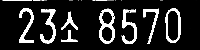

23소8570

1 picture


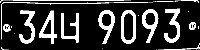

34너9093

2 picture


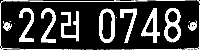

22러0748

3 picture


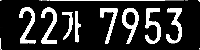

22가7953

4 picture


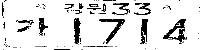

강원33가1714

5 picture


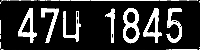

47나1843

6 picture


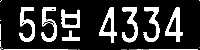

55보4334

7 picture


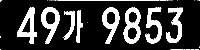

49가9853

8 picture


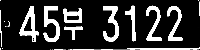

45부3122

9 picture


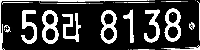

58라8138

10 picture


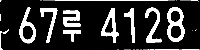

67루4128

11 picture


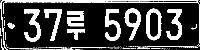

37루5903

12 picture


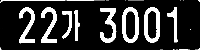

20주3907

13 picture


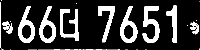

66더7651

14 picture


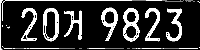

20거9823

15 picture


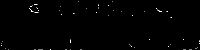

강원35가1357

16 picture


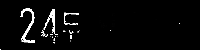

24두9328

17 picture


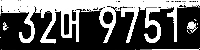

32머9751

18 picture


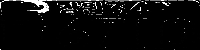

강원34가6714

19 picture


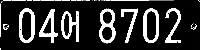

04어8702

20 picture


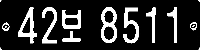

49보8511

21 picture


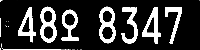

48오8347

22 picture


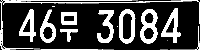

46무3084

23 picture


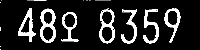

48오8359

24 picture


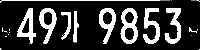

49가9853

25 picture


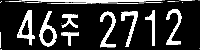

46주2712

26 picture


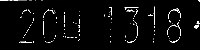

20너1318

27 picture


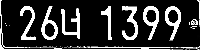

26너1399

28 picture


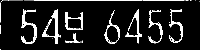

54보6455

29 picture


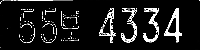

55나4334

30 picture


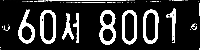

60서8001

31 picture


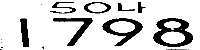

50나1798

32 picture


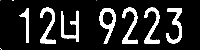

12너9223

33 picture


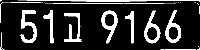

51고9166

34 picture


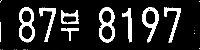

23버8177

35 picture


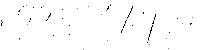

03우1399

36 picture


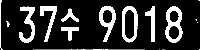

37수9018

37 picture


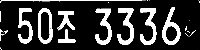

50조3036

38 picture


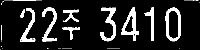

22주3410

39 picture


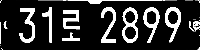

31로2899

40 picture


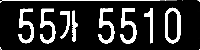

55가5510

41 picture


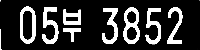

05부3852

42 picture


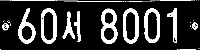

60서8001

43 picture


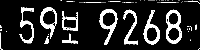

59보9268

44 picture


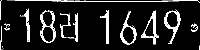

18러1649

45 picture


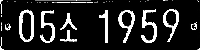

05소1959

46 picture


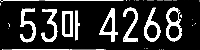

33마4268

47 picture


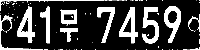

41무7459

48 picture


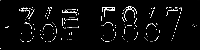

36로5867

49 picture


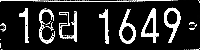

18러1649

50 picture


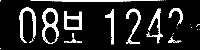

08보1242

51 picture


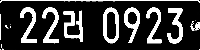

22러0823

52 picture


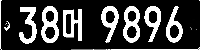

38머9896

53 picture


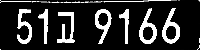

51고9166

54 picture


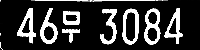

46무3084

55 picture


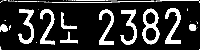

32노2382

56 picture


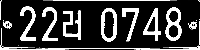

22러0748

57 picture


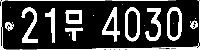

21무4030

58 picture


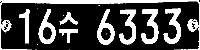

16수6333

59 picture


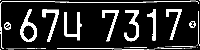

67나7317

60 picture


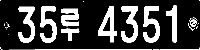

35루4351

61 picture


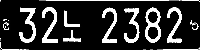

32노2382

62 picture


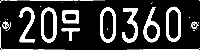

20무0360

63 picture


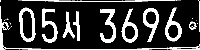

05서3696

64 picture


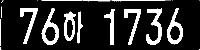

36하1736

65 picture


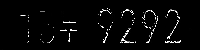

29우3219

66 picture


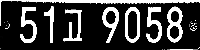

51고9058

67 picture


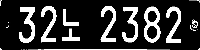

32노2382

68 picture


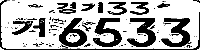

경기33거6533

69 picture


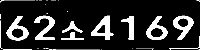

62소4169

70 picture


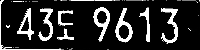

43도9613

71 picture


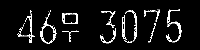

46무3075

72 picture


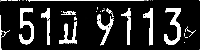

51고9113

73 picture


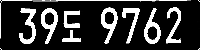

39도9762

74 picture


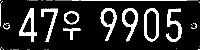

47우9905

75 picture


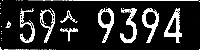

59수9394

76 picture


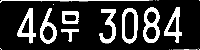

46무3084

77 picture


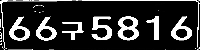

66구5816

78 picture


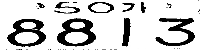

50나8813

79 picture


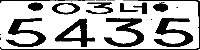

03너5435

80 picture


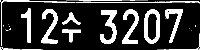

12수3207

81 picture


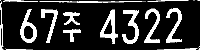

67주4322

82 picture


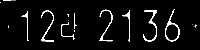

12라2136

83 picture


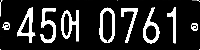

45어0761

84 picture


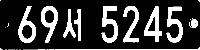

69서5245

85 picture


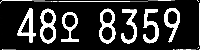

48오8359

86 picture


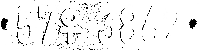

07우3862

87 picture


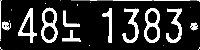

48노1383

88 picture


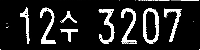

12수3907

89 picture


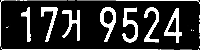

17거9524

90 picture


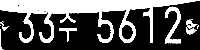

33주5612

91 picture


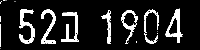

52고1904

92 picture


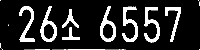

26소6557

93 picture


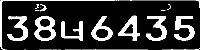

38너6435

94 picture


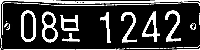

05보1912

95 picture


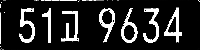

51고9654

96 picture


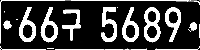

66구5689

97 picture


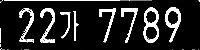

22가7789

98 picture


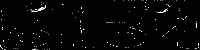

01가6134

99 picture


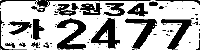

경원34가2477

100 picture


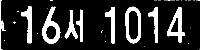

66서1014

101 picture


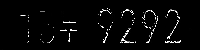

29우3219

102 picture


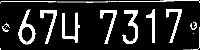

67나7317

103 picture


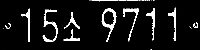

15소9711

104 picture


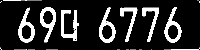

69다6776

105 picture


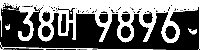

38머9896

106 picture


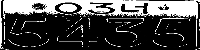

03너5435

107 picture


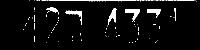

42고4331

108 picture


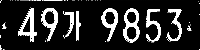

49가9853

109 picture


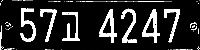

57고4247

110 picture


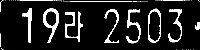

19라2503

111 picture


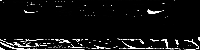

강원33가1357

112 picture


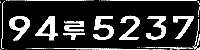

84보9237

113 picture


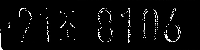

21나8106

114 picture


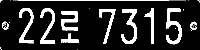

22로7315

115 picture


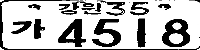

강원35가4518

116 picture


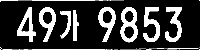

49가9853

117 picture


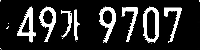

49가9707

118 picture


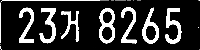

33러8245

119 picture


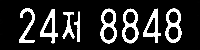

24저8848

120 picture


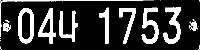

04나1753

121 picture


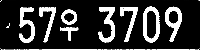

57우3709

122 picture


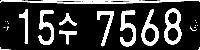

15소7568

123 picture


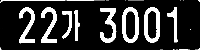

20주3907

124 picture


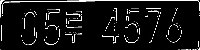

05루4576

125 picture


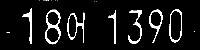

18어1390

126 picture


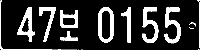

47보0155

127 picture


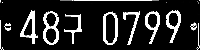

48구0799

128 picture


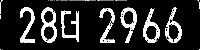

28다2966

129 picture


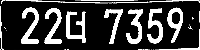

22더7359

130 picture


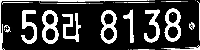

58라8138

131 picture


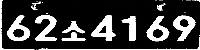

62소4169

132 picture


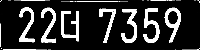

22더7359

133 picture


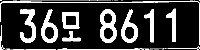

36모8611

134 picture


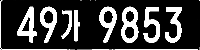

49가9853

135 picture


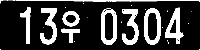

13우0304

136 picture


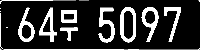

64무5097

137 picture


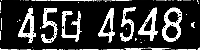

45더4548

138 picture


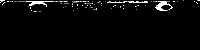

강원33가1714

139 picture


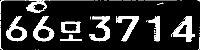

66모3714

140 picture


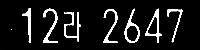

12라2647

141 picture


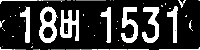

18버1531

142 picture


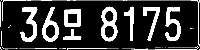

36모8175

143 picture


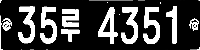

35루4351

144 picture


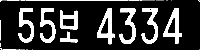

55보4334

145 picture


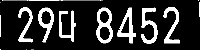

29다8452

146 picture


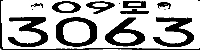

09모3063

147 picture


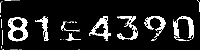

81도4390

148 picture


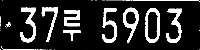

37루5903

149 picture


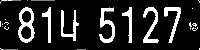

01나5127

150 picture


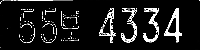

55나4334

151 picture


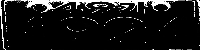

경9가4924

152 picture


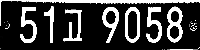

51고9058

153 picture


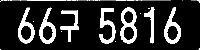

66구5816

154 picture


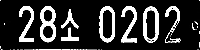

28소0202

155 picture


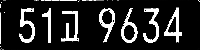

51고9654

156 picture


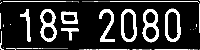

18무2080

157 picture


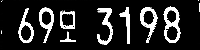

69모3198

158 picture


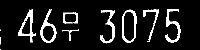

46무3075

159 picture


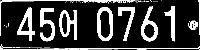

45어0761

160 picture


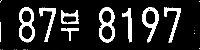

23버8177

161 picture


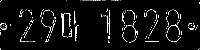

29마1828

162 picture


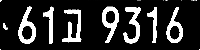

61고9316

163 picture


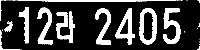

12버2405

164 picture


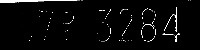

57우3284

165 picture


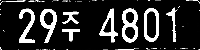

29주4801

166 picture


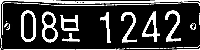

05보1912

167 picture


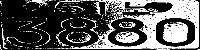

경기노3880

168 picture


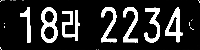

18라2234

169 picture


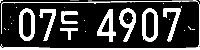

07두4907

170 picture


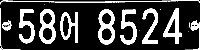

58어8524

171 picture


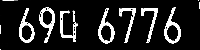

69다6776

172 picture


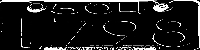

50나1798

173 picture


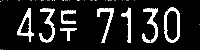

43두7130

174 picture


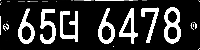

65더6478

175 picture


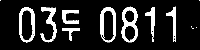

03두0811

176 picture


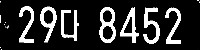

29다8452

177 picture


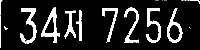

34저7266

178 picture


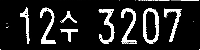

12수3907

179 picture


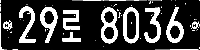

29로8036

180 picture


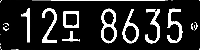

12모8635

181 picture


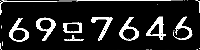

69모7646

182 picture


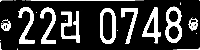

22러0748

183 picture


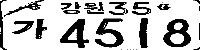

강원35가4518

184 picture


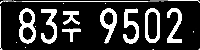

83주9502

185 picture


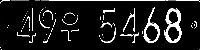

49우5468

186 picture


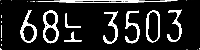

68노3503

187 picture


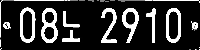

08노2910

188 picture


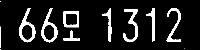

66모1312

189 picture


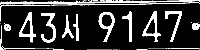

43서9417

190 picture


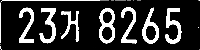

33러8245

191 picture


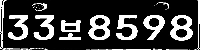

33보8598

192 picture


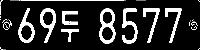

69두8577

193 picture


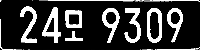

24모9309

194 picture


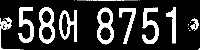

58어8751

195 picture


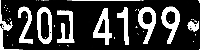

20고4799

196 picture


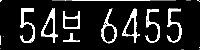

54보6455

197 picture


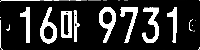

16마9731

198 picture


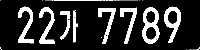

22가7789

199 picture


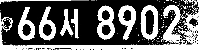

66서8902

200 picture


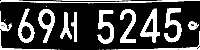

69서5245

201 picture


IndexError: ignored

In [99]:
for i in range(len(predict_list)):
  print(i, 'picture')
  cv2_imshow(np.reshape(x_test[i], (50, 200))* 255)
  print(predict_list[i])
  print()